# 邏輯迴歸的梯度下降（Gradient Descent）

## 目標

在這個 lab 中，你將會：

- 更新（套用）邏輯迴歸的梯度下降流程。

- 在熟悉的資料集上觀察並探索梯度下降的行為。

In [13]:
import sys, os
import copy, math
import numpy as np
try:
    %matplotlib widget
except:
    %matplotlib inline
    print("Colab not support matplotlib widget")
import matplotlib.pyplot as plt
from pathlib import Path

#region 匯入資料
def find_repo_root(marker="README.md"):
    cur = Path.cwd()
    while cur != cur.parent:  # 防止無限迴圈，到達檔案系統根目錄就停
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    return None


def import_data_from_github():
    import os, urllib.request, pathlib, shutil
    
    def isRunningInColab() -> bool:
        return "google.colab" in sys.modules

    def isRunningInJupyterLab() -> bool:
        try:
            import jupyterlab
            return True
        except ImportError:
            return False
        
    def detect_env():
        from IPython import get_ipython
        if isRunningInColab():
            return "Colab"
        elif isRunningInJupyterLab():
            return "JupyterLab"
        elif "notebook" in str(type(get_ipython())).lower():
            return "Jupyter Notebook"
        else:
            return "Unknown"
        
    def get_utils_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/utils"
        else:
            return Path.cwd() / "utils"

    env = detect_env()
    UTILS_DIR = get_utils_dir(env)
    REPO_DIR = "Machine-Learning-Lab"

    #shutil.rmtree(UTILS_DIR, ignore_errors=True)
    os.makedirs(UTILS_DIR, exist_ok=True)

    BASE = f"https://raw.githubusercontent.com/mz038197/{REPO_DIR}/main"
    urllib.request.urlretrieve(f"{BASE}/utils/lab_utils_common_classification.py", f"{UTILS_DIR}/lab_utils_common_classification.py")
    urllib.request.urlretrieve(f"{BASE}/utils/plt_quad_logistic.py", f"{UTILS_DIR}/plt_quad_logistic.py")
    urllib.request.urlretrieve(f"{BASE}/utils/deeplearning.mplstyle", f"{UTILS_DIR}/deeplearning.mplstyle")


repo_root = find_repo_root()

if repo_root is None:
    import_data_from_github()
    repo_root = Path.cwd()
    

os.chdir(repo_root)
print(f"✅ 切換工作目錄至 {Path.cwd()}")
sys.path.append(str(repo_root)) if str(repo_root) not in sys.path else None
print(f"✅ 加入到系統路徑")

from utils.lab_utils_common_classification import  dlc, plot_data, plt_tumor_data, sigmoid, compute_cost_logistic
from utils.plt_quad_logistic import plt_quad_logistic, plt_prob

plt.style.use('utils/deeplearning.mplstyle')
print("✅ 匯入模組及設定繪圖樣式")
#endregion


✅ 切換工作目錄至 d:\Work\Python\Machine-Learning-Lab
✅ 加入到系統路徑
✅ 匯入模組及設定繪圖樣式


<br>

## 資料集
我們先使用與「決策邊界（Decision Boundary）」lab 相同的雙特徵資料集。

In [14]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train = np.array([0, 0, 0, 1, 1, 1])

和之前一樣，我們會使用一個輔助函式來繪製資料。

- 標籤為 $y=1$ 的資料點會以紅色叉叉表示
- 標籤為 $y=0$ 的資料點會以藍色圓點表示

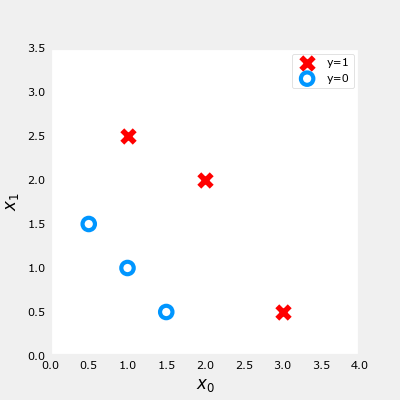

In [15]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

<br>

## 邏輯迴歸的梯度下降

回想梯度下降（Gradient Descent）演算法會使用梯度來更新參數：

$$
\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}
$$

其中每一次迭代會同時更新所有 $w_j$（對所有 $j$），而梯度為：

$$
\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}
$$

- m 是資料集中訓練樣本的數量  

- $f_{\mathbf{w},b}(x^{(i)})$ 是模型的預測值，而 $y^{(i)}$ 是目標值

- 對邏輯迴歸模型  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    其中 $g(z)$ 是 sigmoid 函數：  
    $g(z) = \frac{1}{1+e^{-z}}$   
    


### 梯度下降的實作
梯度下降演算法的實作可以拆成兩個部分：
- 實作上方公式 (1) 的迴圈。也就是下方的 `gradient_descent`；在選修與練習 lab 中通常會直接提供。
- 計算目前梯度（上方公式 (2)、(3)）。也就是下方的 `compute_gradient_logistic`；在本週的 practice lab 中，你會被要求自行實作這部分。

#### 計算梯度：程式碼說明
這段程式會針對所有 $w_j$ 與 $b$ 實作上方公式 (2)、(3)。

實作方式有很多種，這裡採用的流程如下：
- 初始化用來累加 `dj_dw` 與 `dj_db` 的變數
- 對每個樣本：

    - 計算該樣本的誤差 $g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) - \mathbf{y}^{(i)}$
    - 對該樣本中的每個輸入值 $x_{j}^{(i)}$：

        - 將誤差乘上輸入 $x_{j}^{(i)}$，並累加到 `dj_dw` 對應的元素（對應上方公式 2）
    - 將誤差累加到 `dj_db`（對應上方公式 3）

- 最後用樣本總數（m）去除 `dj_db` 與 `dj_dw`
- 注意：在 numpy 中，$\mathbf{x}^{(i)}$ 對應 `X[i,:]` 或 `X[i]`，而 $x_{j}^{(i)}$ 對應 `X[i,j]`

In [16]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    
    #YOUR CODE HERE
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
    # YOUR CODE END HERE

    return dj_db, dj_dw  

請使用下方的 cell 來檢查梯度函數的實作是否正確。

In [17]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]


**預期輸出**
``` 
dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]
```

#### 梯度下降程式碼
上方公式 (1) 的迴圈實作如下。請花點時間對照程式中的各個步驟與上方公式之間的關係。

In [18]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing


接著在我們的資料集上執行梯度下降。

In [19]:
w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 0.684610468560574   
Iteration 1000: Cost 0.1590977666870457   
Iteration 2000: Cost 0.08460064176930078   
Iteration 3000: Cost 0.05705327279402531   
Iteration 4000: Cost 0.04290759421682   
Iteration 5000: Cost 0.03433847729884557   
Iteration 6000: Cost 0.02860379802212006   
Iteration 7000: Cost 0.02450156960879306   
Iteration 8000: Cost 0.02142370332569295   
Iteration 9000: Cost 0.019030137124109114   

updated parameters: w:[5.28123029 5.07815608], b:-14.222409982019837


#### 繪製梯度下降的結果：

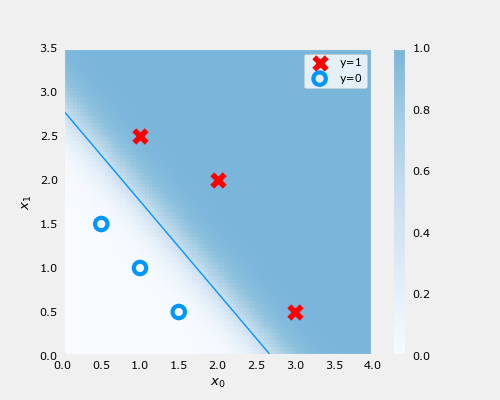

In [20]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability 
plt_prob(ax, w_out, b_out)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')   
ax.axis([0, 4, 0, 3.5])
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c=dlc["dlblue"], lw=1)
plt.show()

在上圖中：
 - 陰影顏色代表 $y=1$ 的機率（也就是套用決策邊界之前的機率輸出）
 - 決策邊界是「機率 = 0.5」的位置所形成的那條線
 

<br>

## 另一個資料集
我們回到單一變數的資料集。當模型只有兩個參數 $w$、$b$ 時，我們可以用等高線圖（contour plot）把成本函數畫出來，更直覺地了解梯度下降到底在做什麼。

In [21]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

和之前一樣，我們會使用一個輔助函式來繪製資料。

- 標籤為 $y=1$ 的資料點會以紅色叉叉表示
- 標籤為 $y=0$ 的資料點會以藍色圓點表示

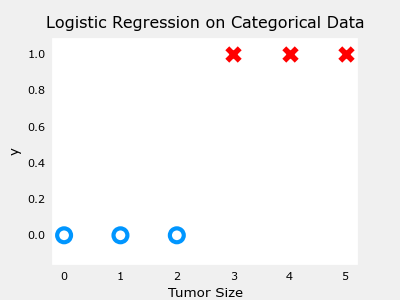

In [22]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
plt_tumor_data(x_train, y_train, ax)
plt.show()

在下方的圖中，請嘗試：
- 在右上角的等高線圖內點擊，以改變 $w$ 與 $b$。

    - 變更可能需要 1～2 秒才會反映
    - 注意左上角圖中的 cost 會跟著改變
    - 注意 cost 是由每個樣本的 loss 累積而來（垂直虛線）

- 點擊橘色按鈕來執行梯度下降。

    - 注意 cost 會穩定下降（等高線圖與 cost 圖顯示的是 log(cost)）
    - 在等高線圖中再次點擊會重設模型，方便你重新跑一次

- 若要重設整張圖，請重新執行這個 cell

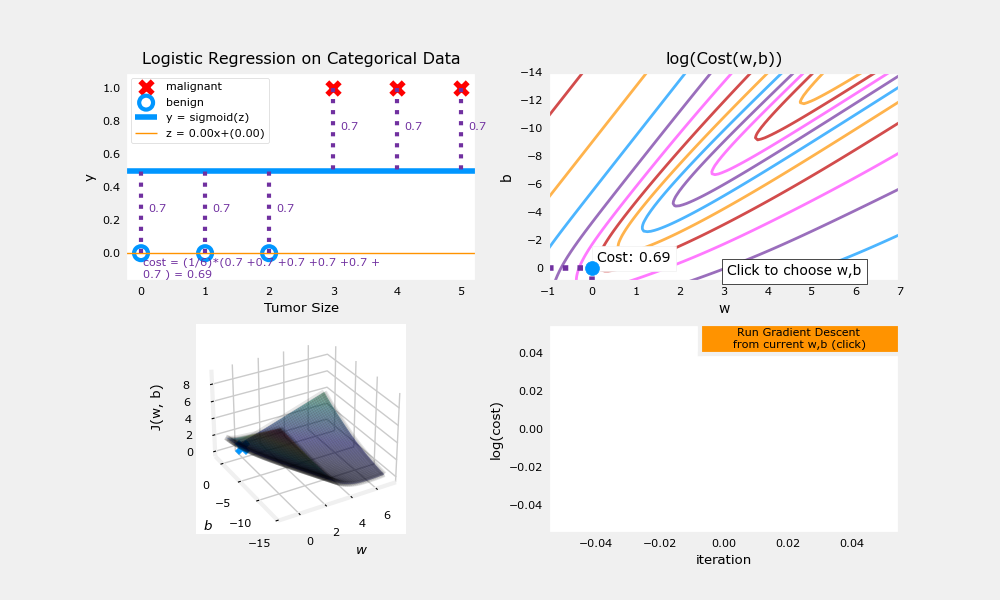

In [23]:
w_range = np.array([-1, 7])
b_range = np.array([1, -14])
quad = plt_quad_logistic( x_train, y_train, w_range, b_range )

<br>

## 恭喜！

你已經：

- 檢視了邏輯斯迴歸梯度計算的公式與程式實作

- 並且在以下情境中實際使用了這些程式：

    - 探索單一變數資料集
    
    - 探索雙變數資料集